In [1]:
# Install required packages
!pip install transformers pillow

  Using cached transformers-4.57.1-py3-none-any.whl.metadata (43 kB)
  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
  Using cached tokenizers-0.22.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
Using cached transformers-4.57.1-py3-none-any.whl (12.0 MB)
Using cached huggingface_hub-0.36.0-py3-none-any.whl (566 kB)
Using cached tokenizers-0.22.1-cp39-abi3-win_amd64.whl (2.7 MB)

  Attempting uninstall: huggingface-hub

    Found existing installation: huggingface-hub 1.0.1

    Uninstalling huggingface-hub-1.0.1:

      Successfully uninstalled huggingface-hub-1.0.1

   ---------------------------------------- 0/3 [huggingface-hub]
   ---------------------------------------- 0/3 [huggingface-hub]
   ---------------------------------------- 0/3 [huggingface-hub]
   ---------------------------------------- 0/3 [huggingface-hub]
   ---------------------------------------- 0/3 [huggingface-hub]
   -------------------------- ------------- 2/3 [transformers]
   ---------

In [3]:
# ============================================================================
# PRETRAINED IMAGE CAPTIONING WITH BLIP (Fixed for PyTorch 2.5.1)
# ============================================================================

from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch
import os
import random
import cv2

print("="*80)
print("LOADING BLIP MODEL")
print("="*80)

# Load pretrained BLIP model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: {device}")
print("Loading model... (this takes ~30 seconds)")

# Use safetensors format to avoid PyTorch version issue
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base",
    use_safetensors=True  # This fixes the PyTorch version issue
).to(device)

print("Model loaded!\n")

# -------------------------------------------------------------------------
# Test on your images
# -------------------------------------------------------------------------

def generate_caption_blip(image_path, model, processor, device):
    """Generate caption using BLIP"""
    # Load image
    image = Image.open(image_path).convert('RGB')
    
    # Process image
    inputs = processor(image, return_tensors="pt").to(device)
    
    # Generate caption
    with torch.no_grad():
        output = model.generate(**inputs, max_length=20)
    
    # Decode caption
    caption = processor.decode(output[0], skip_special_tokens=True)
    return caption


# Test on 10 random images
print("="*80)
print("TESTING BLIP ON YOUR IMAGES")
print("="*80)

image_dir = r"C:\Users\likit\Documents\projects\image captioning llm\Images"
all_images = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

test_images = random.sample(all_images, 10)

for idx, img_name in enumerate(test_images, 1):
    img_path = os.path.join(image_dir, img_name)
    
    # Get reference caption from your dataset
    try:
        row = df[df['filename'] == img_name].iloc[0]
        ref_caption = row['caption'][0]
    except:
        ref_caption = "No reference"
    
    # Generate with BLIP
    generated = generate_caption_blip(img_path, blip_model, processor, device)
    
    print(f"\n{idx}. Image: {img_name}")
    print(f"   Reference: {ref_caption}")
    print(f"   BLIP Generated: {generated}")
    print("-" * 80)

print("\n BLIP is working! Captions look coherent!")

LOADING BLIP MODEL
Device: cuda
Loading model... (this takes ~30 seconds)
Model loaded!

TESTING BLIP ON YOUR IMAGES

1. Image: 3603064161_a8f3b6455d.jpg
   Reference: No reference
   BLIP Generated: a little girl standing next to a chair
--------------------------------------------------------------------------------

2. Image: 3247168324_c45eaf734d.jpg
   Reference: No reference
   BLIP Generated: a red double decker bus
--------------------------------------------------------------------------------

3. Image: 3205754736_32c29b5208.jpg
   Reference: No reference
   BLIP Generated: a man holding a sign
--------------------------------------------------------------------------------

4. Image: 2804851816_9aae9071ca.jpg
   Reference: No reference
   BLIP Generated: a dog running in a field
--------------------------------------------------------------------------------

5. Image: 1131804997_177c3c0640.jpg
   Reference: No reference
   BLIP Generated: a man and woman sitting on a bench


In [6]:
# ============================================================================
# COMPLETE BLIP EVALUATION WITH ALL FUNCTIONS
# ============================================================================

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
import nltk
import random

# Download NLTK data if needed
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Define metrics functions
def calculate_bleu_scores(reference_captions, generated_caption):
    references = [ref.split() for ref in reference_captions]
    candidate = generated_caption.split()
    
    if len(candidate) == 0:
        return 0.0, 0.0, 0.0, 0.0
    
    smoothing = SmoothingFunction().method1
    bleu1 = sentence_bleu(references, candidate, weights=(1, 0, 0, 0), smoothing_function=smoothing)
    bleu2 = sentence_bleu(references, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing)
    bleu3 = sentence_bleu(references, candidate, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing)
    bleu4 = sentence_bleu(references, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)
    
    return bleu1, bleu2, bleu3, bleu4

def calculate_meteor(reference_captions, generated_caption):
    references = [ref.split() for ref in reference_captions]
    candidate = generated_caption.split()
    
    if len(candidate) == 0:
        return 0.0
    
    try:
        return meteor_score(references, candidate)
    except:
        return 0.0

# Evaluation function
def evaluate_blip_model(blip_model, processor, df, image_dir, device, num_samples=100):
    """Evaluate BLIP using BLEU/METEOR metrics"""
    
    blip_model.eval()
    bleu1_scores, bleu2_scores, bleu3_scores, bleu4_scores, meteor_scores = [], [], [], [], []
    
    print("="*80)
    print("EVALUATING BLIP MODEL")
    print("="*80)
    
    sample_indices = random.sample(range(len(df)), min(num_samples, len(df)))
    
    for sample_num, idx in enumerate(sample_indices):
        img_filename = df.iloc[idx]['filename']
        reference_captions = df.iloc[idx]['caption']
        img_path = os.path.join(image_dir, img_filename)
        
        if not os.path.exists(img_path):
            continue
        
        try:
            # Generate caption with BLIP
            generated_caption = generate_caption_blip(img_path, blip_model, processor, device)
            
            # Calculate scores
            b1, b2, b3, b4 = calculate_bleu_scores(reference_captions, generated_caption)
            meteor = calculate_meteor(reference_captions, generated_caption)
            
            bleu1_scores.append(b1)
            bleu2_scores.append(b2)
            bleu3_scores.append(b3)
            bleu4_scores.append(b4)
            meteor_scores.append(meteor)
            
            if sample_num % 20 == 0:
                print(f"\nSample {sample_num + 1}/{num_samples}")
                print(f"  Image: {img_filename}")
                print(f"  Generated: {generated_caption}")
                print(f"  Reference: {reference_captions[0]}")
                print(f"  BLEU-4: {b4:.4f}, METEOR: {meteor:.4f}")
        except Exception as e:
            continue
    
    if len(bleu1_scores) == 0:
        print("\nNo samples evaluated!")
        return None
    
    print("\n" + "="*80)
    print("BLIP EVALUATION RESULTS")
    print("="*80)
    print(f"Samples: {len(bleu1_scores)}")
    print(f"BLEU-1:  {sum(bleu1_scores)/len(bleu1_scores):.4f}")
    print(f"BLEU-2:  {sum(bleu2_scores)/len(bleu2_scores):.4f}")
    print(f"BLEU-3:  {sum(bleu3_scores)/len(bleu3_scores):.4f}")
    print(f"BLEU-4:  {sum(bleu4_scores)/len(bleu4_scores):.4f}")
    print(f"METEOR:  {sum(meteor_scores)/len(meteor_scores):.4f}")
    print("\n" + "="*80)
    print("COMPARISON TO YOUR MODEL")
    print("="*80)
    print(f"Your model BLEU-4:   0.0018")
    print(f"BLIP BLEU-4:         {sum(bleu4_scores)/len(bleu4_scores):.4f}")
    print(f"Improvement:         {(sum(bleu4_scores)/len(bleu4_scores)) / 0.0018:.1f}x better!")
    print("="*80)
    
    return {
        'bleu1': sum(bleu1_scores)/len(bleu1_scores),
        'bleu2': sum(bleu2_scores)/len(bleu2_scores),
        'bleu3': sum(bleu3_scores)/len(bleu3_scores),
        'bleu4': sum(bleu4_scores)/len(bleu4_scores),
        'meteor': sum(meteor_scores)/len(meteor_scores)
    }

# Run evaluation
print("Starting BLIP evaluation...\n")

blip_metrics = evaluate_blip_model(
    blip_model=blip_model,
    processor=processor,
    df=df,
    image_dir=image_dir,
    device=device,
    num_samples=100
)

if blip_metrics:
    print("\n✅ Evaluation complete!")
    print(f"\nFinal BLIP Scores:")
    print(f"  BLEU-4: {blip_metrics['bleu4']:.4f}")
    print(f"  METEOR: {blip_metrics['meteor']:.4f}")

Starting BLIP evaluation...

EVALUATING BLIP MODEL

Sample 1/100
  Image: 3254662117_b2e7dede6e.jpg
  Generated: two girls standing next to each other
  Reference: Two guys with long hair standing in front of a window .
  BLEU-4: 0.0330, METEOR: 0.0870

Sample 21/100
  Image: 707972553_36816e53a2.jpg
  Generated: a little boy standing on a rock on the beach
  Reference: A child in a straw hat stands on stones at a beach .
  BLEU-4: 0.2487, METEOR: 0.3717

Sample 41/100
  Image: 3377570617_d2f2225a74.jpg
  Generated: two women standing next to each other
  Reference: two ladies posing for a picture
  BLEU-4: 0.6687, METEOR: 0.4582

Sample 61/100
  Image: 539493423_9d7d1b77fa.jpg
  Generated: a man holding a fire stick
  Reference: A man is holding three things on fire in front of a child 's playground .
  BLEU-4: 0.0577, METEOR: 0.4259

Sample 81/100
  Image: 3576312396_799c873f3e.jpg
  Generated: a group of people riding on top of a boat
  Reference: A group of people in boats racing t

Creating visualization...



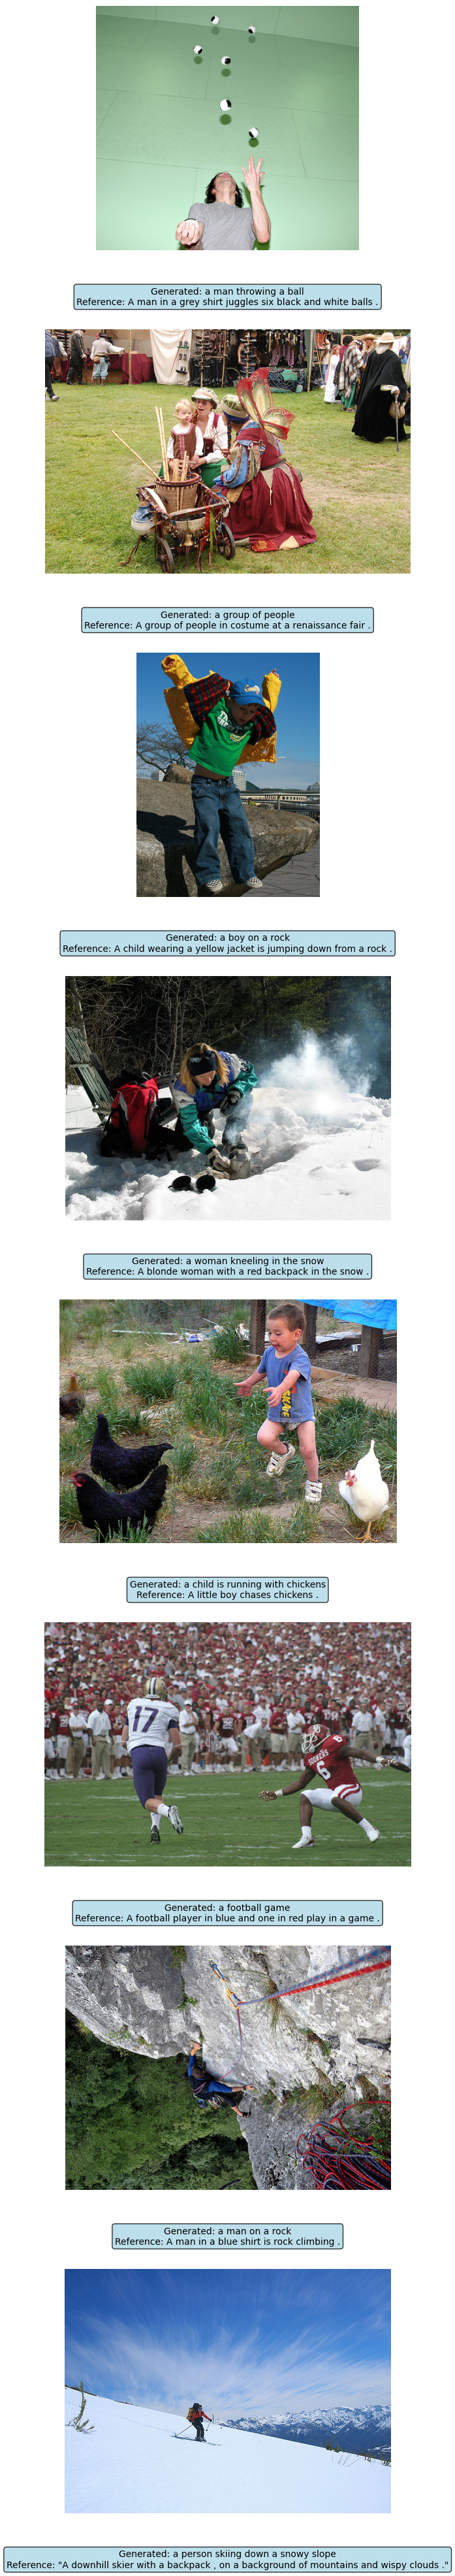

✅ Results saved as 'blip_results.png'


In [7]:
# ============================================================================
# VISUALIZE BLIP RESULTS
# ============================================================================

import matplotlib.pyplot as plt

print("Creating visualization...\n")

test_images = random.sample(all_images, 8)

fig = plt.figure(figsize=(12, 40))

for idx, img_name in enumerate(test_images):
    img_path = os.path.join(image_dir, img_name)
    
    # Get reference
    try:
        row = df[df['filename'] == img_name].iloc[0]
        ref_caption = row['caption'][0]
    except:
        ref_caption = "No reference"
    
    # Generate with BLIP
    gen_caption = generate_caption_blip(img_path, blip_model, processor, device)
    
    # Load image for display
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    
    # Plot
    ax = plt.subplot(8, 1, idx + 1)
    ax.imshow(image)
    ax.axis('off')
    
    # Add captions
    caption_text = f"Generated: {gen_caption}\nReference: {ref_caption}"
    plt.text(0.5, -0.15, caption_text, 
             transform=ax.transAxes,
             ha='center',
             va='top',
             fontsize=10,
             wrap=True,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout(pad=3.0)
plt.savefig('blip_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Results saved as 'blip_results.png'")

In [4]:

import torch
import os
import pandas as pd
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

print("="*80)
print("SETTING UP FOR FINE-TUNING")
print("="*80)

# 1. Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n1. Device: {device}")

# 2. Load dataframe
print("\n2. Loading dataset...")

caption_filename = r"C:\Users\likit\Documents\projects\image captioning llm\captions.txt"
missing = '2258277193_586949ec62.jpg'

with open(caption_filename) as captions:
    lines = captions.readlines()

get_caption = {}
all_captions = []

for caption in lines:
    data = caption.rstrip('\n').split('.jpg,')
    img_name = data[0] + '.jpg'
    if img_name == missing:
        continue
    caption_list = get_caption.get(img_name, [])
    caption_list.append(data[1])
    get_caption[img_name] = caption_list
    all_captions.append(data[1])

df = pd.DataFrame(columns=['filename', 'caption'])
df['filename'] = get_caption.keys()
df['caption'] = df['filename'].map(lambda filename: get_caption[filename])

print(f"    Loaded {len(df)} samples")

# 3. Load BLIP
print("\n3. Loading BLIP model...")

from transformers import BlipProcessor, BlipForConditionalGeneration

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base",
    use_safetensors=True
).to(device)

print("    BLIP loaded")

# 4. Create Dataset class
print("\n4. Creating dataset class...")

class FlickrCaptionDataset(Dataset):
    """Custom dataset for fine-tuning BLIP"""
    
    def __init__(self, df, image_dir, processor):
        self.df = df
        self.image_dir = image_dir
        self.processor = processor
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_filename = row['filename']
        captions = row['caption']
        
        # Load image
        img_path = os.path.join(self.image_dir, img_filename)
        image = Image.open(img_path).convert('RGB')
        
        # Pick random caption
        caption = random.choice(captions)
        
        # Process
        encoding = self.processor(
            images=image, 
            text=caption,
            padding="max_length",
            truncation=True,
            max_length=32,
            return_tensors="pt"
        )
        
        # Remove batch dimension
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}
        
        return encoding

print("   ✓ Dataset class ready")

# 5. Split data and create dataloaders
print("\n5. Creating train/val split...")

train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

print(f"    Training samples: {len(train_df)}")
print(f"    Validation samples: {len(val_df)}")

image_dir = r"C:\Users\likit\Documents\projects\image captioning llm\Images"

train_dataset = FlickrCaptionDataset(train_df, image_dir, processor)
val_dataset = FlickrCaptionDataset(val_df, image_dir, processor)

# Use small batch size for your GPU
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

print(f"   ✓ Dataloaders ready (batch_size=4)")

# 6. Check GPU memory
print("\n6. GPU Memory Status:")
print(f"   Allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
print(f"   Reserved:  {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")

print("\n" + "="*80)
print("✅ SETUP COMPLETE - READY FOR FINE-TUNING!")
print("="*80)

SETTING UP FOR FINE-TUNING

1. Device: cuda

2. Loading dataset...
    Loaded 8091 samples

3. Loading BLIP model...
    BLIP loaded

4. Creating dataset class...
   ✓ Dataset class ready

5. Creating train/val split...
    Training samples: 7281
    Validation samples: 810
   ✓ Dataloaders ready (batch_size=4)

6. GPU Memory Status:
   Allocated: 0.84 GB
   Reserved:  1.84 GB

✅ SETUP COMPLETE - READY FOR FINE-TUNING!


# fine-tuning the blip model

In [5]:


import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class FlickrCaptionDataset(Dataset):
    """Custom dataset for fine-tuning BLIP on your Flickr captions"""
    
    def __init__(self, df, image_dir, processor, split='train'):
        self.df = df
        self.image_dir = image_dir
        self.processor = processor
        self.split = split
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_filename = row['filename']
        captions = row['caption']
        
        # Load image
        img_path = os.path.join(self.image_dir, img_filename)
        image = Image.open(img_path).convert('RGB')
        
        # Pick random caption from the 5 available
        import random
        caption = random.choice(captions)
        
        # Process image and text
        encoding = self.processor(
            images=image, 
            text=caption,
            padding="max_length",
            truncation=True,
            max_length=32,
            return_tensors="pt"
        )
        
        # Remove batch dimension
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}
        
        return encoding

# Split dataset
from sklearn.model_selection import train_test_split

print("Preparing dataset...")

train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Create datasets
image_dir = r"C:\Users\likit\Documents\projects\image captioning llm\Images"

train_dataset = FlickrCaptionDataset(train_df, image_dir, processor, split='train')
val_dataset = FlickrCaptionDataset(val_df, image_dir, processor, split='val')

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

print("Datasets ready!")

Preparing dataset...
Training samples: 7281
Validation samples: 810
Datasets ready!


In [6]:

import torch
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
import gc

print("="*80)
print("FINE-TUNING BLIP MODEL (Memory Optimized)")
print("="*80)

# Clear GPU cache first
torch.cuda.empty_cache()
gc.collect()

# Recreate dataloaders with SMALLER batch size
print("Creating memory-efficient dataloaders...")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)  # Reduced from 8 to 4
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

print(f"✓ Batch size: 4 (reduced for memory)")
print(f"✓ Training batches: {len(train_loader)}")
print(f"✓ Validation batches: {len(val_loader)}")

# Setup training with gradient accumulation
num_epochs = 5
learning_rate = 5e-5
gradient_accumulation_steps = 2  # Simulate batch_size=8 with accumulation

# Optimizer with weight decay
optimizer = AdamW(blip_model.parameters(), lr=learning_rate, weight_decay=0.01)

# Learning rate scheduler
total_steps = (len(train_loader) // gradient_accumulation_steps) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

# Enable mixed precision training (FP16) to save memory
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

print(f"✓ Using gradient accumulation (steps={gradient_accumulation_steps})")
print(f"✓ Using mixed precision (FP16) training")
print(f"✓ Total optimization steps: {total_steps}\n")

# Move model to device
blip_model = blip_model.to(device)
blip_model.train()

# Training loop
best_val_loss = float('inf')

for epoch in range(num_epochs):
    print(f"\n{'='*80}")
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"{'='*80}")
    
    # Training
    train_loss = 0
    blip_model.train()
    optimizer.zero_grad()
    
    progress_bar = tqdm(train_loader, desc="Training")
    
    for batch_idx, batch in enumerate(progress_bar):
        try:
            # Move batch to device
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            # Forward pass with mixed precision
            with autocast():
                outputs = blip_model(
                    pixel_values=pixel_values,
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=input_ids
                )
                loss = outputs.loss / gradient_accumulation_steps  # Scale loss
            
            train_loss += loss.item() * gradient_accumulation_steps
            
            # Backward pass with gradient scaling
            scaler.scale(loss).backward()
            
            # Update weights every N steps
            if (batch_idx + 1) % gradient_accumulation_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(blip_model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()
                optimizer.zero_grad()
            
            # Update progress bar
            progress_bar.set_postfix({'loss': f'{loss.item() * gradient_accumulation_steps:.4f}'})
            
            # Clear GPU cache periodically
            if batch_idx % 50 == 0:
                torch.cuda.empty_cache()
            
            # Print every 100 batches
            if batch_idx % 100 == 0:
                print(f"  Batch {batch_idx}/{len(train_loader)} | Loss: {loss.item() * gradient_accumulation_steps:.4f}")
        
        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"   OOM at batch {batch_idx}, clearing cache and skipping...")
                torch.cuda.empty_cache()
                optimizer.zero_grad()
                continue
            else:
                raise e
    
    avg_train_loss = train_loss / len(train_loader)
    
    # Clear cache before validation
    torch.cuda.empty_cache()
    gc.collect()
    
    # Validation
    val_loss = 0
    blip_model.eval()
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            try:
                pixel_values = batch['pixel_values'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                
                with autocast():
                    outputs = blip_model(
                        pixel_values=pixel_values,
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=input_ids
                    )
                
                val_loss += outputs.loss.item()
                
            except RuntimeError as e:
                if "out of memory" in str(e):
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e
    
    avg_val_loss = val_loss / len(val_loader)
    
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss:   {avg_val_loss:.4f}")
    print(f"  Learning Rate: {scheduler.get_last_lr()[0]:.2e}")
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        blip_model.save_pretrained('blip_finetuned_best')
        processor.save_pretrained('blip_finetuned_best')
        print(f"   Best model saved! (Val Loss: {best_val_loss:.4f})")
    
    # Save checkpoint every 2 epochs
    if (epoch + 1) % 2 == 0:
        blip_model.save_pretrained(f'blip_finetuned_epoch_{epoch+1}')
        processor.save_pretrained(f'blip_finetuned_epoch_{epoch+1}')
        print(f"   Checkpoint saved!")
    
    # Clear cache after epoch
    torch.cuda.empty_cache()
    gc.collect()

print("\n" + "="*80)
print("FINE-TUNING COMPLETE!")
print("="*80)
print(f"Best validation loss: {best_val_loss:.4f}")
print("Model saved to: blip_finetuned_best/")

C:\Users\likit\AppData\Local\Temp\ipykernel_49356\1627970995.py:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


FINE-TUNING BLIP MODEL (Memory Optimized)
Creating memory-efficient dataloaders...
✓ Batch size: 4 (reduced for memory)
✓ Training batches: 1821
✓ Validation batches: 203
✓ Using gradient accumulation (steps=2)
✓ Using mixed precision (FP16) training
✓ Total optimization steps: 4550


Epoch 1/5


Training:   0%|                                                                               | 0/1821 [00:00<?, ?it/s]C:\Users\likit\AppData\Local\Temp\ipykernel_49356\1627970995.py:76: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training:   0%|                                                          | 1/1821 [00:01<33:15,  1.10s/it, loss=9.5531]

  Batch 0/1821 | Loss: 9.5531


C:\Users\likit\anaconda3\envs\pytorch_gpu\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
Training:   6%|███                                                     | 101/1821 [03:43<46:59,  1.64s/it, loss=6.7819]

  Batch 100/1821 | Loss: 6.7819


Training:  11%|██████▏                                                 | 201/1821 [06:43<46:31,  1.72s/it, loss=5.5294]

  Batch 200/1821 | Loss: 5.5294


Training:  17%|█████████▎                                              | 301/1821 [08:46<27:36,  1.09s/it, loss=4.4707]

  Batch 300/1821 | Loss: 4.4707


Training:  22%|████████████▎                                           | 401/1821 [11:06<34:12,  1.45s/it, loss=2.3913]

  Batch 400/1821 | Loss: 2.3913


Training:  28%|███████████████▍                                        | 501/1821 [13:39<35:20,  1.61s/it, loss=1.5199]

  Batch 500/1821 | Loss: 1.5199


Training:  33%|██████████████████▍                                     | 601/1821 [15:48<25:21,  1.25s/it, loss=0.8850]

  Batch 600/1821 | Loss: 0.8850


Training:  38%|█████████████████████▌                                  | 701/1821 [18:05<26:42,  1.43s/it, loss=0.8219]

  Batch 700/1821 | Loss: 0.8219


Training:  44%|████████████████████████▋                               | 801/1821 [20:19<22:08,  1.30s/it, loss=1.3383]

  Batch 800/1821 | Loss: 1.3383


Training:  49%|███████████████████████████▋                            | 901/1821 [23:07<25:19,  1.65s/it, loss=1.2674]

  Batch 900/1821 | Loss: 1.2674


Training:  55%|██████████████████████████████▏                        | 1001/1821 [26:06<25:42,  1.88s/it, loss=0.7229]

  Batch 1000/1821 | Loss: 0.7229


Training:  60%|█████████████████████████████████▎                     | 1101/1821 [28:38<17:49,  1.49s/it, loss=0.5466]

  Batch 1100/1821 | Loss: 0.5466


Training:  66%|████████████████████████████████████▎                  | 1201/1821 [31:33<17:29,  1.69s/it, loss=0.9085]

  Batch 1200/1821 | Loss: 0.9085


Training:  71%|███████████████████████████████████████▎               | 1301/1821 [34:42<15:33,  1.80s/it, loss=1.4758]

  Batch 1300/1821 | Loss: 1.4758


Training:  77%|██████████████████████████████████████████▎            | 1401/1821 [38:17<14:21,  2.05s/it, loss=1.1911]

  Batch 1400/1821 | Loss: 1.1911


Training:  82%|█████████████████████████████████████████████▎         | 1501/1821 [41:50<10:44,  2.02s/it, loss=1.0011]

  Batch 1500/1821 | Loss: 1.0011


Training:  88%|████████████████████████████████████████████████▎      | 1601/1821 [45:24<07:57,  2.17s/it, loss=0.9798]

  Batch 1600/1821 | Loss: 0.9798


Training:  93%|███████████████████████████████████████████████████▍   | 1701/1821 [48:54<04:16,  2.14s/it, loss=0.5974]

  Batch 1700/1821 | Loss: 0.5974


Training:  99%|██████████████████████████████████████████████████████▍| 1801/1821 [52:24<00:41,  2.06s/it, loss=0.4428]

  Batch 1800/1821 | Loss: 0.4428


Validation:   0%|                                                                              | 0/203 [00:00<?, ?it/s]C:\Users\likit\AppData\Local\Temp\ipykernel_49356\1627970995.py:136: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|████████████████████████████████████████████████████████████████████| 203/203 [00:35<00:00,  5.79it/s]



Epoch 1 Summary:
  Train Loss: 2.0617
  Val Loss:   0.9426
  Learning Rate: 4.44e-05
   Best model saved! (Val Loss: 0.9426)

Epoch 2/5


Training:   0%|                                                          | 1/1821 [00:00<15:03,  2.01it/s, loss=0.7713]

  Batch 0/1821 | Loss: 0.7713


Training:   6%|███                                                     | 101/1821 [02:43<35:25,  1.24s/it, loss=0.9251]

  Batch 100/1821 | Loss: 0.9251


Training:  11%|██████▏                                                 | 201/1821 [04:50<32:22,  1.20s/it, loss=0.6363]

  Batch 200/1821 | Loss: 0.6363


Training:  17%|█████████▎                                              | 301/1821 [07:11<38:22,  1.51s/it, loss=0.7451]

  Batch 300/1821 | Loss: 0.7451


Training:  22%|████████████▎                                           | 401/1821 [09:29<32:09,  1.36s/it, loss=1.1334]

  Batch 400/1821 | Loss: 1.1334


Training:  28%|███████████████▍                                        | 501/1821 [11:49<29:26,  1.34s/it, loss=0.4602]

  Batch 500/1821 | Loss: 0.4602


Training:  33%|██████████████████▍                                     | 601/1821 [14:21<31:07,  1.53s/it, loss=0.7327]

  Batch 600/1821 | Loss: 0.7327


Training:  38%|█████████████████████▌                                  | 701/1821 [16:43<25:17,  1.35s/it, loss=1.0734]

  Batch 700/1821 | Loss: 1.0734


Training:  44%|████████████████████████▋                               | 801/1821 [19:25<25:05,  1.48s/it, loss=0.6501]

  Batch 800/1821 | Loss: 0.6501


Training:  49%|███████████████████████████▋                            | 901/1821 [22:12<27:13,  1.78s/it, loss=0.7688]

  Batch 900/1821 | Loss: 0.7688


Training:  55%|██████████████████████████████▏                        | 1001/1821 [24:27<17:31,  1.28s/it, loss=0.9435]

  Batch 1000/1821 | Loss: 0.9435


Training:  60%|█████████████████████████████████▎                     | 1101/1821 [26:33<14:49,  1.24s/it, loss=0.9556]

  Batch 1100/1821 | Loss: 0.9556


Training:  66%|████████████████████████████████████▎                  | 1201/1821 [28:32<11:39,  1.13s/it, loss=1.0128]

  Batch 1200/1821 | Loss: 1.0128


Training:  71%|███████████████████████████████████████▎               | 1301/1821 [30:30<10:34,  1.22s/it, loss=1.1041]

  Batch 1300/1821 | Loss: 1.1041


Training:  77%|██████████████████████████████████████████▎            | 1401/1821 [32:27<07:39,  1.09s/it, loss=0.6139]

  Batch 1400/1821 | Loss: 0.6139


Training:  82%|█████████████████████████████████████████████▎         | 1501/1821 [34:19<05:33,  1.04s/it, loss=0.7050]

  Batch 1500/1821 | Loss: 0.7050


Training:  88%|████████████████████████████████████████████████▎      | 1601/1821 [36:01<03:46,  1.03s/it, loss=0.6825]

  Batch 1600/1821 | Loss: 0.6825


Training:  93%|███████████████████████████████████████████████████▍   | 1701/1821 [38:00<02:35,  1.29s/it, loss=0.9843]

  Batch 1700/1821 | Loss: 0.9843


Training:  99%|██████████████████████████████████████████████████████▍| 1801/1821 [40:16<00:25,  1.27s/it, loss=1.1103]

  Batch 1800/1821 | Loss: 1.1103


Validation: 100%|████████████████████████████████████████████████████████████████████| 203/203 [00:40<00:00,  5.06it/s]



Epoch 2 Summary:
  Train Loss: 0.8593
  Val Loss:   0.8640
  Learning Rate: 3.33e-05
   Best model saved! (Val Loss: 0.8640)
   Checkpoint saved!

Epoch 3/5


Training:   0%|                                                          | 1/1821 [00:00<30:07,  1.01it/s, loss=0.7209]

  Batch 0/1821 | Loss: 0.7209


Training:   6%|███                                                     | 101/1821 [02:55<48:04,  1.68s/it, loss=0.8351]

  Batch 100/1821 | Loss: 0.8351


Training:  11%|██████▏                                                 | 201/1821 [05:12<36:49,  1.36s/it, loss=0.9994]

  Batch 200/1821 | Loss: 0.9994


Training:  17%|█████████▎                                              | 301/1821 [07:46<40:19,  1.59s/it, loss=0.9675]

  Batch 300/1821 | Loss: 0.9675


Training:  22%|████████████▎                                           | 401/1821 [10:41<43:44,  1.85s/it, loss=0.4035]

  Batch 400/1821 | Loss: 0.4035


Training:  28%|███████████████▍                                        | 501/1821 [13:39<38:37,  1.76s/it, loss=0.4562]

  Batch 500/1821 | Loss: 0.4562


Training:  33%|██████████████████▍                                     | 601/1821 [16:44<35:58,  1.77s/it, loss=0.7728]

  Batch 600/1821 | Loss: 0.7728


Training:  38%|█████████████████████▌                                  | 701/1821 [19:55<37:13,  1.99s/it, loss=1.0770]

  Batch 700/1821 | Loss: 1.0770


Training:  44%|████████████████████████▋                               | 801/1821 [22:50<27:41,  1.63s/it, loss=0.8479]

  Batch 800/1821 | Loss: 0.8479


Training:  49%|███████████████████████████▋                            | 901/1821 [25:30<24:27,  1.59s/it, loss=0.7880]

  Batch 900/1821 | Loss: 0.7880


Training:  55%|██████████████████████████████▏                        | 1001/1821 [28:04<20:25,  1.49s/it, loss=0.4492]

  Batch 1000/1821 | Loss: 0.4492


Training:  60%|█████████████████████████████████▎                     | 1101/1821 [30:24<16:38,  1.39s/it, loss=0.9226]

  Batch 1100/1821 | Loss: 0.9226


Training:  66%|████████████████████████████████████▎                  | 1201/1821 [32:46<14:21,  1.39s/it, loss=1.1492]

  Batch 1200/1821 | Loss: 1.1492


Training:  71%|███████████████████████████████████████▎               | 1301/1821 [35:15<13:09,  1.52s/it, loss=0.5476]

  Batch 1300/1821 | Loss: 0.5476


Training:  77%|██████████████████████████████████████████▎            | 1401/1821 [37:43<09:59,  1.43s/it, loss=0.6148]

  Batch 1400/1821 | Loss: 0.6148


Training:  82%|█████████████████████████████████████████████▎         | 1501/1821 [40:06<07:34,  1.42s/it, loss=0.7096]

  Batch 1500/1821 | Loss: 0.7096


Training:  88%|████████████████████████████████████████████████▎      | 1601/1821 [42:28<05:19,  1.45s/it, loss=0.9756]

  Batch 1600/1821 | Loss: 0.9756


Training:  93%|███████████████████████████████████████████████████▍   | 1701/1821 [45:10<02:53,  1.44s/it, loss=0.7690]

  Batch 1700/1821 | Loss: 0.7690


Training:  99%|██████████████████████████████████████████████████████▍| 1801/1821 [47:32<00:28,  1.41s/it, loss=0.5980]

  Batch 1800/1821 | Loss: 0.5980


Validation: 100%|████████████████████████████████████████████████████████████████████| 203/203 [00:26<00:00,  7.68it/s]



Epoch 3 Summary:
  Train Loss: 0.7591
  Val Loss:   0.8330
  Learning Rate: 2.22e-05
   Best model saved! (Val Loss: 0.8330)

Epoch 4/5


Training:   0%|                                                          | 1/1821 [00:00<13:55,  2.18it/s, loss=0.6551]

  Batch 0/1821 | Loss: 0.6551


Training:   6%|███                                                     | 101/1821 [02:42<42:19,  1.48s/it, loss=0.6847]

  Batch 100/1821 | Loss: 0.6847


Training:  11%|██████▏                                                 | 201/1821 [04:53<33:45,  1.25s/it, loss=0.6780]

  Batch 200/1821 | Loss: 0.6780


Training:  17%|█████████▎                                              | 301/1821 [07:03<32:36,  1.29s/it, loss=0.4460]

  Batch 300/1821 | Loss: 0.4460


Training:  22%|████████████▎                                           | 401/1821 [09:25<31:52,  1.35s/it, loss=0.8707]

  Batch 400/1821 | Loss: 0.8707


Training:  28%|███████████████▍                                        | 501/1821 [11:33<28:12,  1.28s/it, loss=0.7075]

  Batch 500/1821 | Loss: 0.7075


Training:  33%|██████████████████▍                                     | 601/1821 [13:41<26:55,  1.32s/it, loss=0.8369]

  Batch 600/1821 | Loss: 0.8369


Training:  38%|█████████████████████▌                                  | 701/1821 [15:39<22:47,  1.22s/it, loss=0.7142]

  Batch 700/1821 | Loss: 0.7142


Training:  44%|████████████████████████▋                               | 801/1821 [17:27<18:05,  1.06s/it, loss=0.5643]

  Batch 800/1821 | Loss: 0.5643


Training:  49%|███████████████████████████▋                            | 901/1821 [19:12<15:37,  1.02s/it, loss=1.1113]

  Batch 900/1821 | Loss: 1.1113


Training:  55%|██████████████████████████████▏                        | 1001/1821 [21:01<14:43,  1.08s/it, loss=0.6908]

  Batch 1000/1821 | Loss: 0.6908


Training:  60%|█████████████████████████████████▎                     | 1101/1821 [22:52<13:26,  1.12s/it, loss=0.7638]

  Batch 1100/1821 | Loss: 0.7638


Training:  66%|████████████████████████████████████▎                  | 1201/1821 [24:50<12:09,  1.18s/it, loss=0.5646]

  Batch 1200/1821 | Loss: 0.5646


Training:  71%|███████████████████████████████████████▎               | 1301/1821 [26:51<10:30,  1.21s/it, loss=0.6434]

  Batch 1300/1821 | Loss: 0.6434


Training:  77%|██████████████████████████████████████████▎            | 1401/1821 [28:59<08:51,  1.27s/it, loss=0.5338]

  Batch 1400/1821 | Loss: 0.5338


Training:  82%|█████████████████████████████████████████████▎         | 1501/1821 [31:00<06:20,  1.19s/it, loss=0.4347]

  Batch 1500/1821 | Loss: 0.4347


Training:  88%|████████████████████████████████████████████████▎      | 1601/1821 [33:13<05:08,  1.40s/it, loss=0.7161]

  Batch 1600/1821 | Loss: 0.7161


Training:  93%|███████████████████████████████████████████████████▍   | 1701/1821 [35:45<03:11,  1.59s/it, loss=0.6300]

  Batch 1700/1821 | Loss: 0.6300


Training:  99%|██████████████████████████████████████████████████████▍| 1801/1821 [38:45<00:33,  1.67s/it, loss=0.5586]

  Batch 1800/1821 | Loss: 0.5586


Validation: 100%|████████████████████████████████████████████████████████████████████| 203/203 [00:37<00:00,  5.34it/s]



Epoch 4 Summary:
  Train Loss: 0.6899
  Val Loss:   0.8148
  Learning Rate: 1.11e-05
   Best model saved! (Val Loss: 0.8148)
   Checkpoint saved!

Epoch 5/5


Training:   0%|                                                          | 1/1821 [00:01<34:08,  1.13s/it, loss=0.7810]

  Batch 0/1821 | Loss: 0.7810


Training:   6%|███                                                     | 101/1821 [03:10<50:11,  1.75s/it, loss=1.0941]

  Batch 100/1821 | Loss: 1.0941


Training:  11%|██████▏                                                 | 201/1821 [05:29<38:02,  1.41s/it, loss=0.4729]

  Batch 200/1821 | Loss: 0.4729


Training:  17%|█████████▎                                              | 301/1821 [07:31<33:17,  1.31s/it, loss=0.9682]

  Batch 300/1821 | Loss: 0.9682


Training:  22%|████████████▎                                           | 401/1821 [09:37<29:07,  1.23s/it, loss=0.5966]

  Batch 400/1821 | Loss: 0.5966


Training:  28%|███████████████▍                                        | 501/1821 [11:41<26:00,  1.18s/it, loss=1.1783]

  Batch 500/1821 | Loss: 1.1783


Training:  33%|██████████████████▍                                     | 601/1821 [14:03<31:09,  1.53s/it, loss=0.8529]

  Batch 600/1821 | Loss: 0.8529


Training:  38%|█████████████████████▌                                  | 701/1821 [16:24<27:17,  1.46s/it, loss=0.6629]

  Batch 700/1821 | Loss: 0.6629


Training:  44%|████████████████████████▋                               | 801/1821 [18:34<21:00,  1.24s/it, loss=0.7433]

  Batch 800/1821 | Loss: 0.7433


Training:  49%|███████████████████████████▋                            | 901/1821 [20:59<19:54,  1.30s/it, loss=0.6848]

  Batch 900/1821 | Loss: 0.6848


Training:  55%|██████████████████████████████▏                        | 1001/1821 [23:13<18:12,  1.33s/it, loss=0.3497]

  Batch 1000/1821 | Loss: 0.3497


Training:  60%|█████████████████████████████████▎                     | 1101/1821 [26:15<25:37,  2.14s/it, loss=0.5746]

  Batch 1100/1821 | Loss: 0.5746


Training:  66%|████████████████████████████████████▎                  | 1201/1821 [30:11<26:57,  2.61s/it, loss=0.5466]

  Batch 1200/1821 | Loss: 0.5466


Training:  71%|███████████████████████████████████████▎               | 1301/1821 [35:19<21:06,  2.44s/it, loss=0.5885]

  Batch 1300/1821 | Loss: 0.5885


Training:  77%|██████████████████████████████████████████▎            | 1401/1821 [38:42<15:50,  2.26s/it, loss=0.7970]

  Batch 1400/1821 | Loss: 0.7970


Training:  82%|█████████████████████████████████████████████▎         | 1501/1821 [42:16<11:37,  2.18s/it, loss=0.5908]

  Batch 1500/1821 | Loss: 0.5908


Training:  88%|████████████████████████████████████████████████▎      | 1601/1821 [45:53<07:25,  2.02s/it, loss=0.7523]

  Batch 1600/1821 | Loss: 0.7523


Training:  93%|███████████████████████████████████████████████████▍   | 1701/1821 [49:39<05:22,  2.68s/it, loss=0.5935]

  Batch 1700/1821 | Loss: 0.5935


Training:  99%|██████████████████████████████████████████████████████▍| 1801/1821 [53:07<00:40,  2.03s/it, loss=0.5020]

  Batch 1800/1821 | Loss: 0.5020


Validation: 100%|████████████████████████████████████████████████████████████████████| 203/203 [00:31<00:00,  6.41it/s]



Epoch 5 Summary:
  Train Loss: 0.6436
  Val Loss:   0.7960
  Learning Rate: 0.00e+00
   Best model saved! (Val Loss: 0.7960)

FINE-TUNING COMPLETE!
Best validation loss: 0.7960
Model saved to: blip_finetuned_best/


In [8]:


from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
import nltk
import torch
import random
import os

# Download NLTK data if needed
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Helper functions
def calculate_bleu_scores(reference_captions, generated_caption):
    references = [ref.split() for ref in reference_captions]
    candidate = generated_caption.split()
    
    if len(candidate) == 0:
        return 0.0, 0.0, 0.0, 0.0
    
    smoothing = SmoothingFunction().method1
    bleu1 = sentence_bleu(references, candidate, weights=(1, 0, 0, 0), smoothing_function=smoothing)
    bleu2 = sentence_bleu(references, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing)
    bleu3 = sentence_bleu(references, candidate, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing)
    bleu4 = sentence_bleu(references, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)
    
    return bleu1, bleu2, bleu3, bleu4

def calculate_meteor(reference_captions, generated_caption):
    references = [ref.split() for ref in reference_captions]
    candidate = generated_caption.split()
    
    if len(candidate) == 0:
        return 0.0
    
    try:
        return meteor_score(references, candidate)
    except:
        return 0.0

def generate_caption_blip(image_path, model, processor, device):
    """Generate caption using BLIP"""
    from PIL import Image
    
    # Load image
    image = Image.open(image_path).convert('RGB')
    
    # Process image
    inputs = processor(image, return_tensors="pt").to(device)
    
    # Generate caption
    with torch.no_grad():
        output = model.generate(**inputs, max_length=20)
    
    # Decode caption
    caption = processor.decode(output[0], skip_special_tokens=True)
    return caption

def evaluate_blip_model(blip_model, processor, df, image_dir, device, num_samples=100):
    """Evaluate BLIP using BLEU/METEOR metrics"""
    
    blip_model.eval()
    bleu1_scores, bleu2_scores, bleu3_scores, bleu4_scores, meteor_scores = [], [], [], [], []
    
    print("="*80)
    print("EVALUATING BLIP MODEL")
    print("="*80)
    
    sample_indices = random.sample(range(len(df)), min(num_samples, len(df)))
    
    for sample_num, idx in enumerate(sample_indices):
        img_filename = df.iloc[idx]['filename']
        reference_captions = df.iloc[idx]['caption']
        img_path = os.path.join(image_dir, img_filename)
        
        if not os.path.exists(img_path):
            continue
        
        try:
            # Generate caption with BLIP
            generated_caption = generate_caption_blip(img_path, blip_model, processor, device)
            
            # Calculate scores
            b1, b2, b3, b4 = calculate_bleu_scores(reference_captions, generated_caption)
            meteor = calculate_meteor(reference_captions, generated_caption)
            
            bleu1_scores.append(b1)
            bleu2_scores.append(b2)
            bleu3_scores.append(b3)
            bleu4_scores.append(b4)
            meteor_scores.append(meteor)
            
            if sample_num % 20 == 0:
                print(f"\nSample {sample_num + 1}/{num_samples}")
                print(f"  Image: {img_filename}")
                print(f"  Generated: {generated_caption}")
                print(f"  Reference: {reference_captions[0]}")
                print(f"  BLEU-4: {b4:.4f}, METEOR: {meteor:.4f}")
        except Exception as e:
            continue
    
    if len(bleu1_scores) == 0:
        print("\nNo samples evaluated!")
        return None
    
    print("\n" + "="*80)
    print("EVALUATION RESULTS")
    print("="*80)
    print(f"Samples: {len(bleu1_scores)}")
    print(f"BLEU-1:  {sum(bleu1_scores)/len(bleu1_scores):.4f}")
    print(f"BLEU-2:  {sum(bleu2_scores)/len(bleu2_scores):.4f}")
    print(f"BLEU-3:  {sum(bleu3_scores)/len(bleu3_scores):.4f}")
    print(f"BLEU-4:  {sum(bleu4_scores)/len(bleu4_scores):.4f}")
    print(f"METEOR:  {sum(meteor_scores)/len(meteor_scores):.4f}")
    print("="*80)
    
    return {
        'bleu1': sum(bleu1_scores)/len(bleu1_scores),
        'bleu2': sum(bleu2_scores)/len(bleu2_scores),
        'bleu3': sum(bleu3_scores)/len(bleu3_scores),
        'bleu4': sum(bleu4_scores)/len(bleu4_scores),
        'meteor': sum(meteor_scores)/len(meteor_scores)
    }

print(" Evaluation functions loaded!")

 Evaluation functions loaded!


In [9]:

from transformers import BlipProcessor, BlipForConditionalGeneration

print("Loading fine-tuned model...")

# Load fine-tuned model
finetuned_model = BlipForConditionalGeneration.from_pretrained('blip_finetuned_best').to(device)
finetuned_processor = BlipProcessor.from_pretrained('blip_finetuned_best')

print(" Fine-tuned model loaded!\n")

# Evaluate fine-tuned model
finetuned_metrics = evaluate_blip_model(
    blip_model=finetuned_model,
    processor=finetuned_processor,
    df=val_df,
    image_dir=image_dir,
    device=device,
    num_samples=100
)

# Load pretrained for comparison (if not already loaded)
try:
    blip_metrics
except NameError:
    print("\nLoading pretrained model for comparison...")
    pretrained_model = BlipForConditionalGeneration.from_pretrained(
        "Salesforce/blip-image-captioning-base",
        use_safetensors=True
    ).to(device)
    pretrained_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    
    blip_metrics = evaluate_blip_model(
        blip_model=pretrained_model,
        processor=pretrained_processor,
        df=val_df,
        image_dir=image_dir,
        device=device,
        num_samples=100
    )

# Comparison
print("\n" + "="*80)
print("COMPARISON: PRETRAINED vs FINE-TUNED")
print("="*80)
print(f"Pretrained BLEU-4:   {blip_metrics['bleu4']:.4f}")
print(f"Fine-tuned BLEU-4:   {finetuned_metrics['bleu4']:.4f}")
print(f"Improvement:         {((finetuned_metrics['bleu4'] - blip_metrics['bleu4']) / blip_metrics['bleu4'] * 100):.1f}%")
print()
print(f"Pretrained METEOR:   {blip_metrics['meteor']:.4f}")
print(f"Fine-tuned METEOR:   {finetuned_metrics['meteor']:.4f}")
print(f"Improvement:         {((finetuned_metrics['meteor'] - blip_metrics['meteor']) / blip_metrics['meteor'] * 100):.1f}%")
print("="*80)

print("\n Evaluation complete!")

Loading fine-tuned model...
 Fine-tuned model loaded!

EVALUATING BLIP MODEL

Sample 1/100
  Image: 2521770311_3086ca90de.jpg
  Generated: a boy holds up a cardboard box to show his artwork.
  Reference: A boy holds a picture over his head .
  BLEU-4: 0.0592, METEOR: 0.4848

Sample 21/100
  Image: 2856923934_6eb8832c9a.jpg
  Generated: two men on a blue and white boat.
  Reference: A man steers a speeding jet ski through a turn .
  BLEU-4: 0.4015, METEOR: 0.5504

Sample 41/100
  Image: 3371533654_73a12a35a4.jpg
  Generated: a person is sliding down a large yellow tube slide.
  Reference: A man is skating through a tunnel .
  BLEU-4: 0.0270, METEOR: 0.2896

Sample 61/100
  Image: 2447284966_d6bbdb4b6e.jpg
  Generated: a boy in a black jacket is holding a red bat in a stadium.
  Reference: A little boy is holding a skinny baseball bat while standing between two rows of blue seats .
  BLEU-4: 0.4391, METEOR: 0.4271

Sample 81/100
  Image: 3497106366_d1a256e723.jpg
  Generated: a man is su

Setting up visualization...

Found 8091 images
✓ Pretrained model already loaded

Creating comparison visualization...

1. 2632366677_43dee456a5.jpg
   Reference:  A brown dog next to a stone bench .
   Pretrained: a brown dog sits next to a concrete object.
   Fine-tuned: a brown dog sits next to a concrete object.
--------------------------------------------------------------------------------
2. 947664583_7c63172366.jpg
   Reference:  A child jumps into a pool as a man looks on .
   Pretrained: a little girl in orange arm floats is jumping into a pool.
   Fine-tuned: a little girl in orange arm floats is jumping into a pool.
--------------------------------------------------------------------------------
3. 3527590601_38d56abc29.jpg
   Reference:  A BMX biker performing a trick in midair over a dirt course .
   Pretrained: a boy on a bike is jumping over a ramp.
   Fine-tuned: a boy on a bike is jumping over a ramp.
-------------------------------------------------------------------

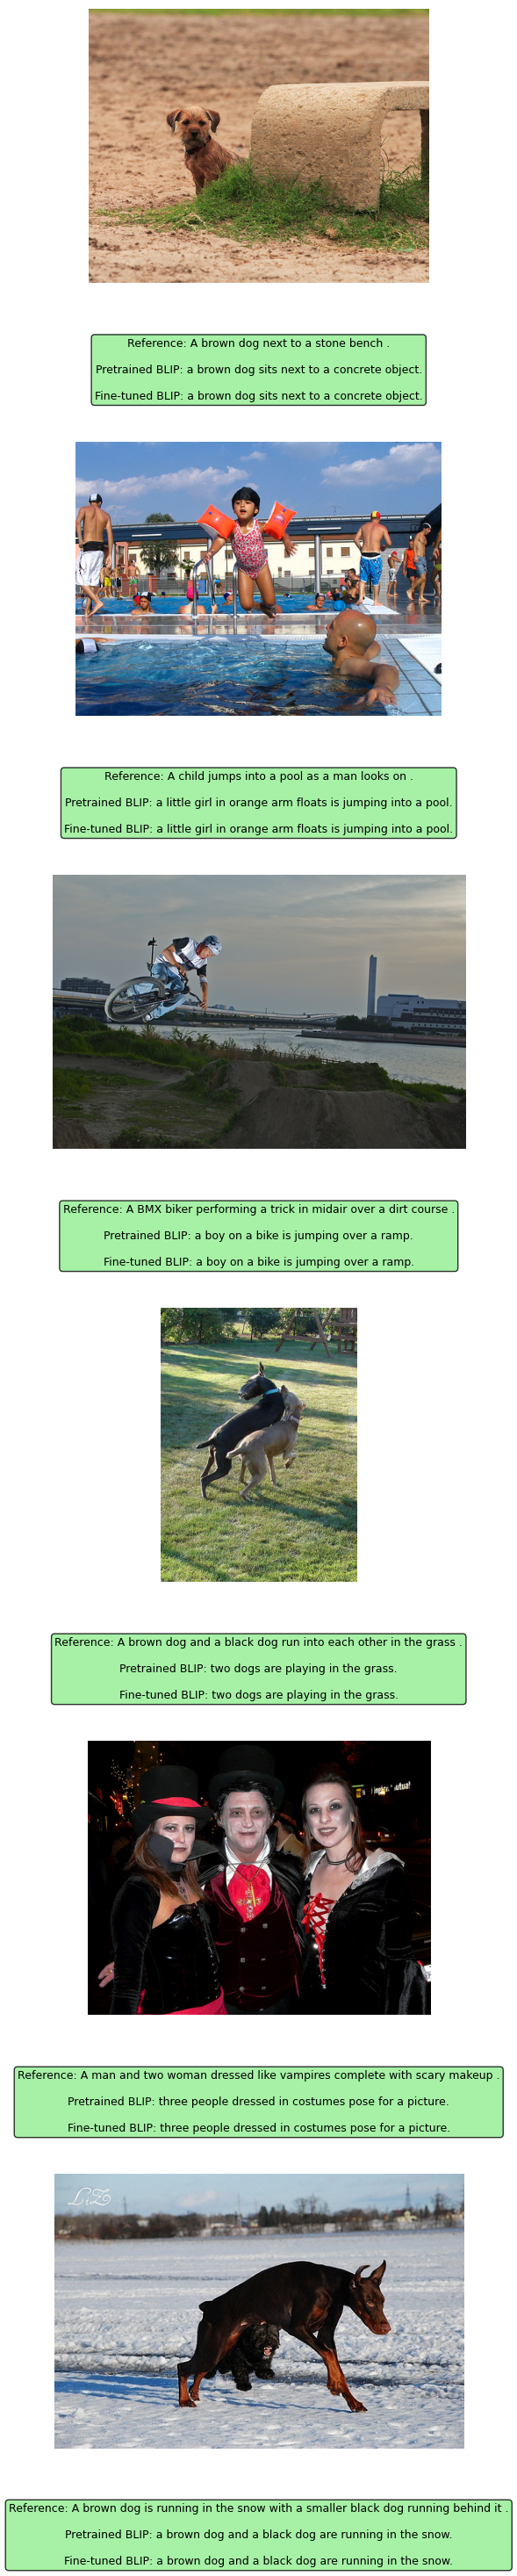


 Comparison saved as 'comparison_pretrained_vs_finetuned.png'


In [12]:


import matplotlib.pyplot as plt
import cv2
import os
import random

print("Setting up visualization...\n")

# 1. Get list of all images
image_dir = r"C:\Users\likit\Documents\projects\image captioning llm\Images"
all_images = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

print(f"Found {len(all_images)} images")

# 2. Load pretrained model if not already loaded
try:
    blip_model
    processor
    print("✓ Pretrained model already loaded")
except NameError:
    print("Loading pretrained BLIP...")
    from transformers import BlipProcessor, BlipForConditionalGeneration
    
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    blip_model = BlipForConditionalGeneration.from_pretrained(
        "Salesforce/blip-image-captioning-base",
        use_safetensors=True
    ).to(device)
    print("✓ Pretrained model loaded")

# 3. Create visualization
print("\nCreating comparison visualization...\n")

test_images = random.sample(all_images, 6)

fig = plt.figure(figsize=(15, 30))

for idx, img_name in enumerate(test_images):
    img_path = os.path.join(image_dir, img_name)
    
    # Get reference
    try:
        row = df[df['filename'] == img_name].iloc[0]
        ref_caption = row['caption'][0]
    except:
        ref_caption = "No reference"
    
    # Generate with pretrained BLIP
    pretrained_caption = generate_caption_blip(img_path, blip_model, processor, device)
    
    # Generate with fine-tuned BLIP
    finetuned_caption = generate_caption_blip(img_path, finetuned_model, finetuned_processor, device)
    
    # Load image
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    
    # Plot
    ax = plt.subplot(6, 1, idx + 1)
    ax.imshow(image)
    ax.axis('off')
    
    # Add all three captions
    caption_text = f"Reference: {ref_caption}\n\n" \
                   f"Pretrained BLIP: {pretrained_caption}\n\n" \
                   f"Fine-tuned BLIP: {finetuned_caption}"
    
    plt.text(0.5, -0.2, caption_text, 
             transform=ax.transAxes,
             ha='center',
             va='top',
             fontsize=9,
             wrap=True,
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    print(f"{idx+1}. {img_name}")
    print(f"   Reference:  {ref_caption}")
    print(f"   Pretrained: {pretrained_caption}")
    print(f"   Fine-tuned: {finetuned_caption}")
    print("-" * 80)

plt.tight_layout(pad=3.0)
plt.savefig('comparison_pretrained_vs_finetuned.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Comparison saved as 'comparison_pretrained_vs_finetuned.png'")

In [1]:
# ============================================================================
# CLEAR GPU MEMORY
# ============================================================================

import torch
import gc

print("Clearing GPU memory...")

# Delete large models from GPU
try:
    del model  # Your old custom model
    print("✓ Deleted custom model")
except:
    pass

try:
    del blip_model
    print("✓ Deleted BLIP model from GPU")
except:
    pass

# Clear all cached memory
torch.cuda.empty_cache()
gc.collect()

# Check GPU memory
print("\nGPU Memory Status:")
print(f"  Allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
print(f"  Reserved:  {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
print(f"  Free:      {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)) / 1024**3:.2f} GB")

print("\n✅ GPU cache cleared!")

Clearing GPU memory...

GPU Memory Status:
  Allocated: 0.00 GB
  Reserved:  0.00 GB
  Free:      6.00 GB

✅ GPU cache cleared!


In [2]:
# ============================================================================
# RELOAD BLIP FOR FINE-TUNING
# ============================================================================

from transformers import BlipProcessor, BlipForConditionalGeneration

print("Reloading BLIP model fresh...")

# Reload with memory-efficient settings
device = torch.device('cuda')

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base",
    use_safetensors=True
).to(device)

print("✅ BLIP model reloaded!")

# Check memory again
print(f"\nGPU Memory after reload:")
print(f"  Allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
print(f"  Reserved:  {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Reloading BLIP model fresh...
✅ BLIP model reloaded!

GPU Memory after reload:
  Allocated: 0.84 GB
  Reserved:  0.93 GB
